# Bellmann Equation und Value Iteration für FrozenLake

In diesem Notebook implementieren wir einen Agenten, der die Bellmann-Gleichung und Value Iteration verwendet, um das FrozenLake-Umfeld zu lösen. Wir verwenden die `gymnasium`-Bibliothek, um die Umgebung zu erstellen und zu interagieren.

Discounted Reward mit $\gamma$ = 0.9 für eine Episode:
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$

Für den Agenten gibt es eine Policy $\pi$, die die Aktion angibt, die der Agent in einem bestimmten Zustand ausführen soll.
$$\pi(a|s) = P[A_t = a | S_t = s]$$

Der Wert eines States kann anhand der State Value Function (V-Wert) berechnet werden:
$$V(s) = \mathbb{E}[G_t | S_t = s]$$

Der Wert einer Aktion kann anhand der Action Value Function (Q-Wert) berechnet werden:
$$Q(s,a) = \mathbb{E}[G_t | S_t = s, A_t = a]$$


Danke dem Optimalitätssatzes von Bellmann, können die Werte für den State und den Actions Value rekursive berechnet werden.
Die Bellmann-Gleichungen für V(s) und Q(s,a) lauten:

$$V(s) = \text{max}_a \sum_{s'} P(s'|s,a) [R(s,a,s') + \gamma V(s')] = \text{max}_{a \in A} Q(s, a)$$

der Q-Wert:
$$Q(s,a) = \sum_{s'} P(s'|s,a) [R(s,a,s') + \gamma V(s')]$$
der V-Wert:
$$V(s) = \text{max}_{a \in A} Q(s, a)$$

### Value iteration Algorithmus
Beim Value Iteration Algorithmus wird die Bellmann-Gleichung iterativ angewendet, um die optimalen Werte für V(s) zu berechnen und daraus die optimale Policy π* abzuleiten. Dabei wird angenommen, dass das Modell der Umgebung (Übergangswahrscheinlichkeiten und Belohnungen) bekannt ist bzw. erlernt wurde.
- Value-based Methode: wir werden die V/Q-Werte iterativ aktualisieren, bis sie konvergieren.
- Model-based Methode: wir benötigen das Modell der Umgebung (Übergangswahrscheinlichkeiten und Belohnungen).
- On-policy Methode: wir berechnen die Werte basierend auf der aktuellen Policy.

Algorithmus Value Iteration:
1. Initialisiere V(s) für alle Zustände s
2. Wiederhole bis zur Konvergenz:
   - Für jeden Zustand s:
     - Setze V(s) = max_a Σ_{s'} P(s'|s,a) [R(s,a,s') + γ V(s')]
3. Extrahiere die optimale Policy π* aus V(s):
   - Für jeden Zustand s:
     - Setze π*(s) = argmax_a Σ_{s'} P(s'|s,a) [R(s,a,s') + γ V(s')]    

### FrozenLake Environment


Das FrozenLake-Umfeld besteht aus einem 4x4-Gitter, in dem der Agent von der Startposition (S) zur Zielposition (G) navigieren muss, während er Löcher (H) vermeidet.
- States: 16 (4x4 Gitter)
- Actions: 4 (links, rechts, oben, unten)

![Value-Iteration-Diagramm](viaq.png)

_Abbildung: Ablauf der Value Iteration für FrozenLake._

Es gibt somit 16 Zustände und 4 mögliche Aktionen in jedem Zustand. Das Ziel des Agenten ist es, von der Startposition (S) zur Zielposition (G) zu gelangen, ohne in ein Loch (H) zu fallen. Der Agent erhält eine Belohnung von 1, wenn er das Ziel erreicht, und 0 für alle anderen Aktionen.

Imports

In [23]:
from typing import Any

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from plotting import action_map
from plotting import plotting_fn
from plotting import plotting_q_values

## Definition des Agenten und der Value Iteration


In [24]:
class FrozenLakeAgent:
    def __init__(self, env: gym.Env, gamma: float = 0.9) -> None:
        self.env = env
        self.observations: int = self.env.observation_space.n
        self.actions: int = self.env.action_space.n
        self.gamma = gamma
        self.state, _ = self.env.reset()
        self.S = range(self.observations)
        self.A = range(self.actions)
        self.rewards = {
            s: {a: dict.fromkeys(self.S, 0.0) for a in self.A} for s in self.S
        }
        self.transitions = {
            s: {a: dict.fromkeys(self.S, 0.0) for a in self.A} for s in self.S
        }
        self.q_values = {s: dict.fromkeys(self.A, 0.0) for s in self.S}

    def get_action(self, state: Any) -> Any:
        q_values = list(self.q_values[state].values())
        return np.argmax(q_values).astype(int)

    def get_random_action(self) -> Any:
        return self.env.action_space.sample()

    def get_samples(self, num_episodes: int) -> None:
        for _ in range(num_episodes):
            action = self.get_random_action()
            new_state, reward, done, _, _ = self.env.step(action)
            self.rewards[self.state][action][new_state] = reward
            self.transitions[self.state][action][new_state] += 1
            if done:
                self.state, _ = self.env.reset()
            else:
                self.state = new_state

    def compute_q_values(self) -> None:
        for s in self.S:
            for a in self.A:
                q_value = 0.0
                transitions_dict = self.transitions[s][a]
                transisions_list = list(transitions_dict.values())
                total_transitions = np.sum(transisions_list).astype(int)
                if total_transitions > 0:
                    for s_next, count in transitions_dict.items():
                        reward = self.rewards[s][a][s_next]
                        best_action = self.get_action(s_next)
                        q_value += (count / total_transitions) * (
                            reward
                            + self.gamma * self.q_values[s_next][best_action]
                        )
                    self.q_values[s][a] = q_value

    def train(self, num_iterations: int, num_episodes: int) -> None:
        self.get_samples(num_episodes=1_000)
        for _ in range(num_iterations):
            self.get_samples(num_episodes=num_episodes)
            self.compute_q_values()
            reward_mean = self.play(num_episodes=20, render=False)
            if reward_mean >= 0.9:
                break

    def play(self, num_episodes: int, render: bool = True) -> float:
        reward_sum = 0.0  
        if render:
            _, ax = plt.subplots(figsize=(8, 8))
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0.0
            while True:
                action = self.get_action(state)
                if render:
                    print(f"State: {state}, Action: {action_map(action)}")
                    plotting_q_values(state, action, self.q_values, ax)
                state, reward, done, _, _ = self.env.step(action)
                total_reward += reward
                if done:
                    reward_sum += total_reward
                    break
            print(f"Episode: {episode} Total Reward: {total_reward}")
        self.env.close()
        return reward_sum / num_episodes

## Aufruf des Agenten und des Environments

In [25]:
env = gym.make("FrozenLake-v1")
agent = FrozenLakeAgent(env)

## Training des Agenten mit Value Iteration

In [26]:
agent.train(num_iterations=10000, num_episodes=1000)


Episode: 0 Total Reward: 0.0
Episode: 1 Total Reward: 0.0
Episode: 2 Total Reward: 0.0
Episode: 3 Total Reward: 0.0
Episode: 4 Total Reward: 0.0
Episode: 5 Total Reward: 0.0
Episode: 6 Total Reward: 0.0
Episode: 7 Total Reward: 0.0
Episode: 8 Total Reward: 0.0
Episode: 9 Total Reward: 0.0
Episode: 10 Total Reward: 0.0
Episode: 11 Total Reward: 0.0
Episode: 12 Total Reward: 0.0
Episode: 13 Total Reward: 0.0
Episode: 14 Total Reward: 0.0
Episode: 15 Total Reward: 0.0
Episode: 16 Total Reward: 0.0
Episode: 17 Total Reward: 0.0
Episode: 18 Total Reward: 0.0
Episode: 19 Total Reward: 0.0
Episode: 0 Total Reward: 0.0
Episode: 1 Total Reward: 0.0
Episode: 2 Total Reward: 0.0
Episode: 3 Total Reward: 0.0
Episode: 4 Total Reward: 0.0
Episode: 5 Total Reward: 0.0
Episode: 6 Total Reward: 0.0
Episode: 7 Total Reward: 0.0
Episode: 8 Total Reward: 0.0
Episode: 9 Total Reward: 0.0
Episode: 10 Total Reward: 0.0
Episode: 11 Total Reward: 0.0
Episode: 12 Total Reward: 0.0
Episode: 13 Total Reward: 0.0


## Spielen mit dem trainierten Agenten

State: 0, Action: Left


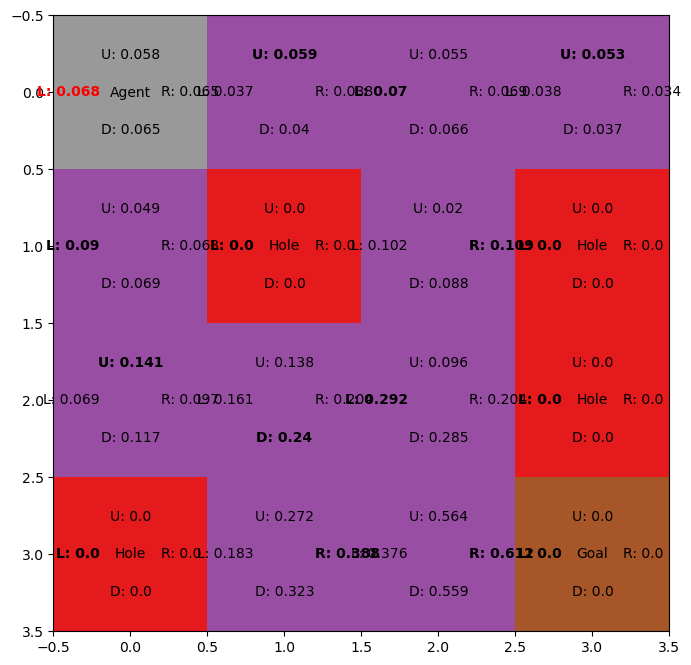

State: 0, Action: Left
State: 4, Action: Left
State: 4, Action: Left
State: 0, Action: Left
State: 4, Action: Left
State: 8, Action: Up
State: 4, Action: Left
State: 8, Action: Up
State: 8, Action: Up
State: 9, Action: Down
State: 8, Action: Up
State: 8, Action: Up
State: 4, Action: Left
State: 4, Action: Left


KeyboardInterrupt: 

In [27]:
agent.play(num_episodes=5)